# Test 1: Measure the over head of starting and stopping the exection model

This benchmark measures how long it takes to start and stop 100:
- Threads
- Sub Interpreters
- Multiprocessing Processes

Execution is in _serial_ and each instance will execute a noop. The goal is to measure the minimal overhead of the execution model.

See [bm_bare.py](bm_bare.py) for the implementation of the test.

Results for a 3.4 GHz Quad-Core Intel Core i5.

[Text(0.5, 1.0, 'Threading, Sub Interpreter and Multiprocessing Benchmark (n=60) Python 3.12.0a7+ (64-bit) revision e1dde486ef'),
 Text(0, 0.5, 'Mean Time for 100 executions (s)'),
 Text(0.5, 0, 'Model')]

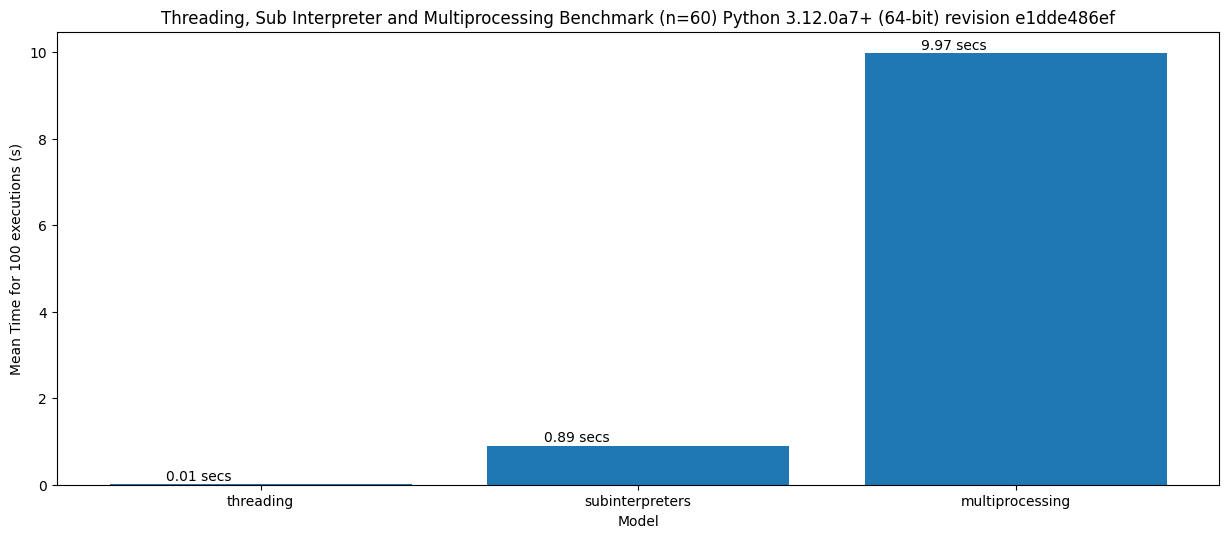

In [2]:
import json
import matplotlib.pyplot as plt
from statistics import mean

plt.rcParams["figure.figsize"] = (15, 6)
plt.rcParams["figure.dpi"] = 100

def pyperf_to_runs(file):

    with open(file) as f:
        data = json.load(f)
        runs = {}
        for benchmark in data["benchmarks"]:
            run_times = []
            for run in benchmark["runs"]:
                if "values" in run:
                    run_times.extend(run["values"])
            runs[benchmark["metadata"]["name"]] = mean(run_times)
        python_version = data["metadata"]["python_version"]
    return runs, python_version, run_times

runs, python_version, run_times = pyperf_to_runs("test1.json")
# Create a bar chart of each run
plt.bar(runs.keys(), runs.values())

# put the value on top of the bar
for i, v in enumerate(runs.values()):
    plt.text(i - 0.25, v + 0.1, f"{round(v, 2)} secs", color='black')

plt.gca().set(title=f'Threading, Sub Interpreter and Multiprocessing Benchmark (n={len(run_times)}) Python {python_version}', ylabel='Mean Time for 100 executions (s)', xlabel='Model')

# Test 2: Measurement of the execution time for parallel execution

This benchmark measures how fast each model can execute a problem in parallel that has high CPU-contention (GIL impacted).

Each test will calculate Pi to 2000 digits using the same algorithm 10 times in parallel. The test will be repeated 60 times to show the mean time taken. 

See [bm_parallel.py](bm_parallel.py) for implementation details.

Results for a 3.4 GHz Quad-Core Intel Core i5.

[Text(0.5, 1.0, 'Execution of Pi to 2000 digits concurrently 10 times on 4 Core CPU (n=60) Python 3.12.0a7+ (64-bit) revision e1dde486ef'),
 Text(0, 0.5, 'Mean Time for executions (s)'),
 Text(0.5, 0, 'Model')]

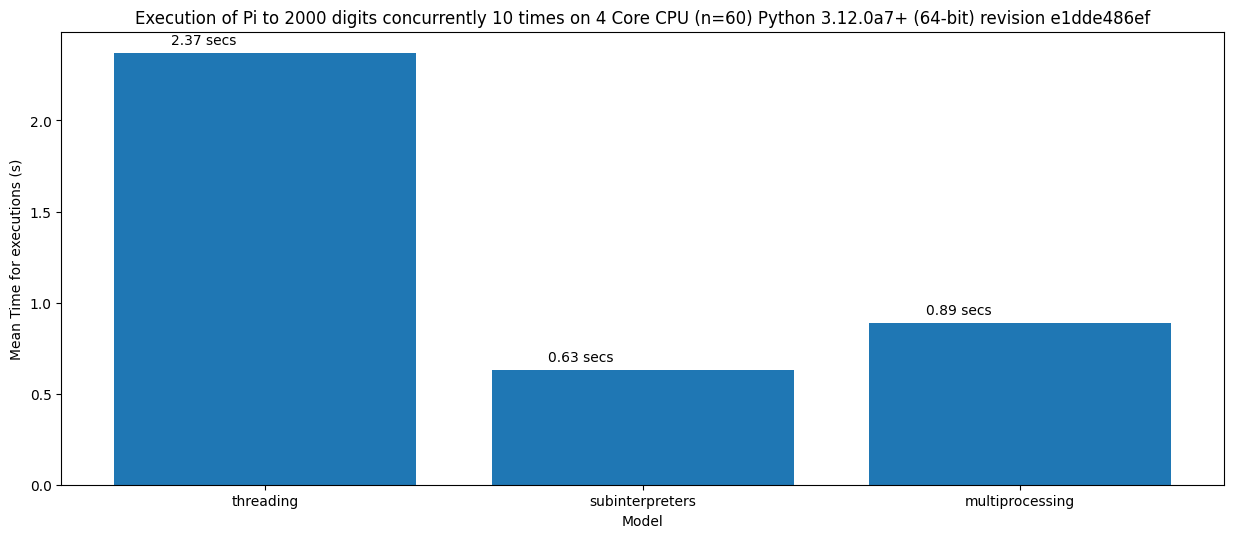

In [3]:
runs, python_version, run_times = pyperf_to_runs("test3.json")
# Create a bar chart of each run
plt.bar(runs.keys(), runs.values())

# put the value on top of the bar
for i, v in enumerate(runs.values()):
    plt.text(i - 0.25, v + 0.05, f"{round(v, 2)} secs", color='black')

plt.gca().set(title=f'Execution of Pi to 2000 digits concurrently 10 times on 4 Core CPU (n={len(run_times)}) Python {python_version}', ylabel='Mean Time for executions (s)', xlabel='Model')

# No site patch

After looking at a profile of `_Py_NewInterpreterFromConfig`, it seemed that ~50% of the execution time is due to initialization of site. The `--no-site` flag is useful for a new process if you don't need packages outside the stdlib, but there isn't a setting for it in sub interpreter API. Interpreter Config has this property, but it's not available in `_xxsubinterpreters.create()` so I wrote a small patch to add it and propagate the changes down to the new sub interpreters.

This is the resulting benchmark compared with the previous results (pydebug is enabled in this build, so the overall numbers will likely be a bit slower) but it shows a relative performance improvement to sub interpreters if no-site is configured.  

[Text(0.5, 1.0, 'Threading, Sub Interpreter and Multiprocessing Benchmark (n=60) Python 3.12.0a7+ (64-bit) revision e1dde486ef'),
 Text(0, 0.5, 'Mean Time for executions (s)'),
 Text(0.5, 0, 'Model')]

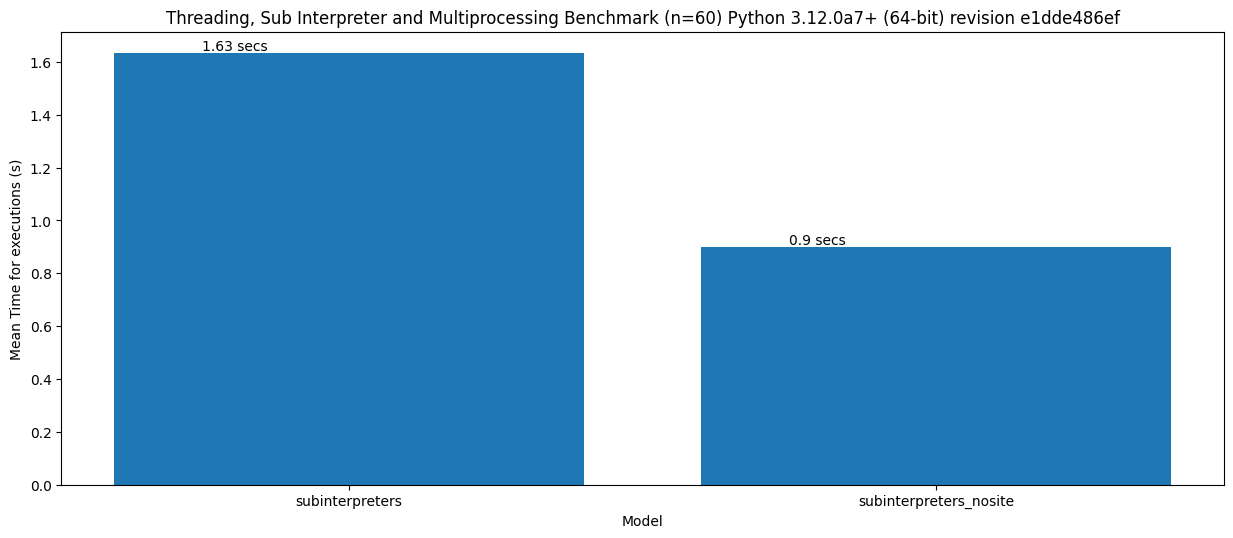

In [8]:
runs, python_version, run_times = pyperf_to_runs("test4.json")
del runs["multiprocessing"]
del runs["threading"]
# Create a bar chart of each run
plt.bar(runs.keys(), runs.values())

# put the value on top of the bar
for i, v in enumerate(runs.values()):
    plt.text(i - 0.25, v + 0.01, f"{round(v, 2)} secs", color='black')

plt.gca().set(title=f'Threading, Sub Interpreter and Multiprocessing Benchmark (n={len(run_times)}) Python {python_version}', ylabel='Mean Time for executions (s)', xlabel='Model')